# Import Libraries

In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from typing import List
from glob import glob
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle

warnings.filterwarnings("ignore")

# Data Loading

In [2]:
datasets_paths = glob("../data/*.csv")
datasets: List[pd.DataFrame] = [pd.read_csv(path) for path in datasets_paths]
datasets_names = [path.split("/")[-1].split(".")[0] for path in datasets_paths]

# Data Preparation

- Treat the records with `anomaly = True` from the dataset, and then impute them.
- Remove the `anomaly` column from the dataset.

In [3]:
for i, dataset in enumerate(datasets):
    if "anomaly" in dataset.columns:
        # Replace anomalies with 'NaN'
        dataset.loc[dataset.anomaly == 1, "value"] = np.nan

        # Remove the 'anomaly' column
        dataset = dataset.drop(columns=["anomaly"])

        # Update the dataset
        datasets[i] = dataset

- Convert the timestamp column to the `datetime` datatype
- Set the timestamp column as the index of the dataframe

In [4]:
for i, dataset in enumerate(datasets):
    # Convert the 'timestamp' column to datetime
    dataset["timestamp"] = pd.to_datetime(dataset["timestamp"])

    # Set the 'timestamp' column as the index
    dataset = dataset.set_index("timestamp")

    # Update the dataset
    datasets[i] = dataset

- Save the intervals of the datasets in a separate file for later use.

In [5]:
datasets_intervals = {}
for dataset, dataset_name in zip(datasets, datasets_names):
    interval = dataset.index.to_series().diff().mode()[0]
    datasets_intervals[dataset_name] = interval

In [6]:
with open("../data/datasets_intervals.pkl", "wb") as f:
    pickle.dump(datasets_intervals, f)

- Remove Outliers

In [7]:
class OutlierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.threshold = threshold
        self.X_mean = None
        self.X_std = None

    def fit(self, X, y=None):
        """Calculate the z-score for each column in the DataFrame"""
        X_copy = X.copy().to_numpy()
        self.X_mean = np.mean(X_copy)
        self.X_std = np.std(X_copy)

        return self

    def __zscore(self, X):
        X = np.nan_to_num(X, copy=True, nan=0)  # Convert the NaN values to 0

        return (X - self.X_mean) / np.std(self.X_std)

    def transform(self, X: pd.DataFrame, y=None):
        """
        remove the rows with z-score > threshold
        """
        X_copy = X.copy()

        z_scores = self.__zscore(X_copy.value)
        outliers = np.abs(z_scores) > self.threshold
        X_copy[outliers] = np.nan

        return pd.DataFrame(X_copy, columns=X.columns, index=X.index)

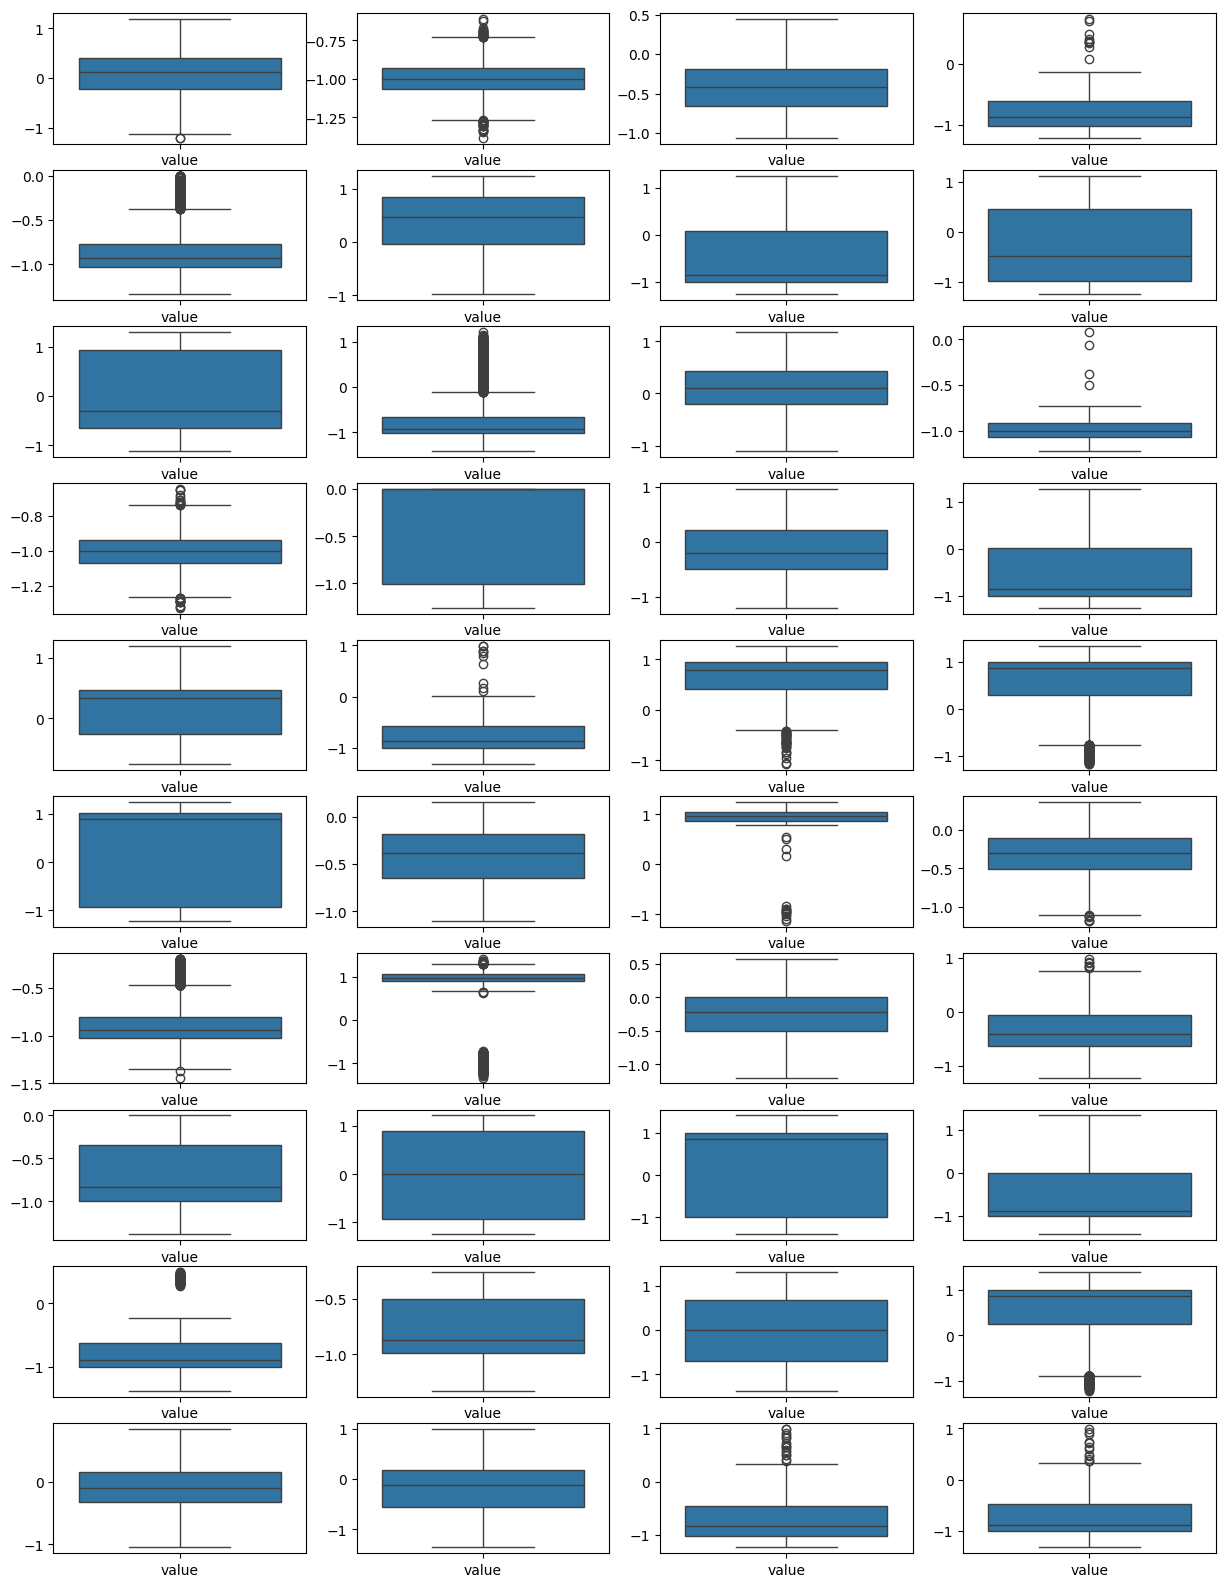

In [8]:
fig, axes = plt.subplots(10, 4, figsize=(15, 20))
for ax, dataset in zip(axes.ravel(), datasets):
    sns.boxplot(dataset, ax=ax)

plt.show()

In [9]:
# datasets with no outliers
no_missing_datasets = [
    OutlierTransformer(threshold=2).fit_transform(dataset) for dataset in datasets
]

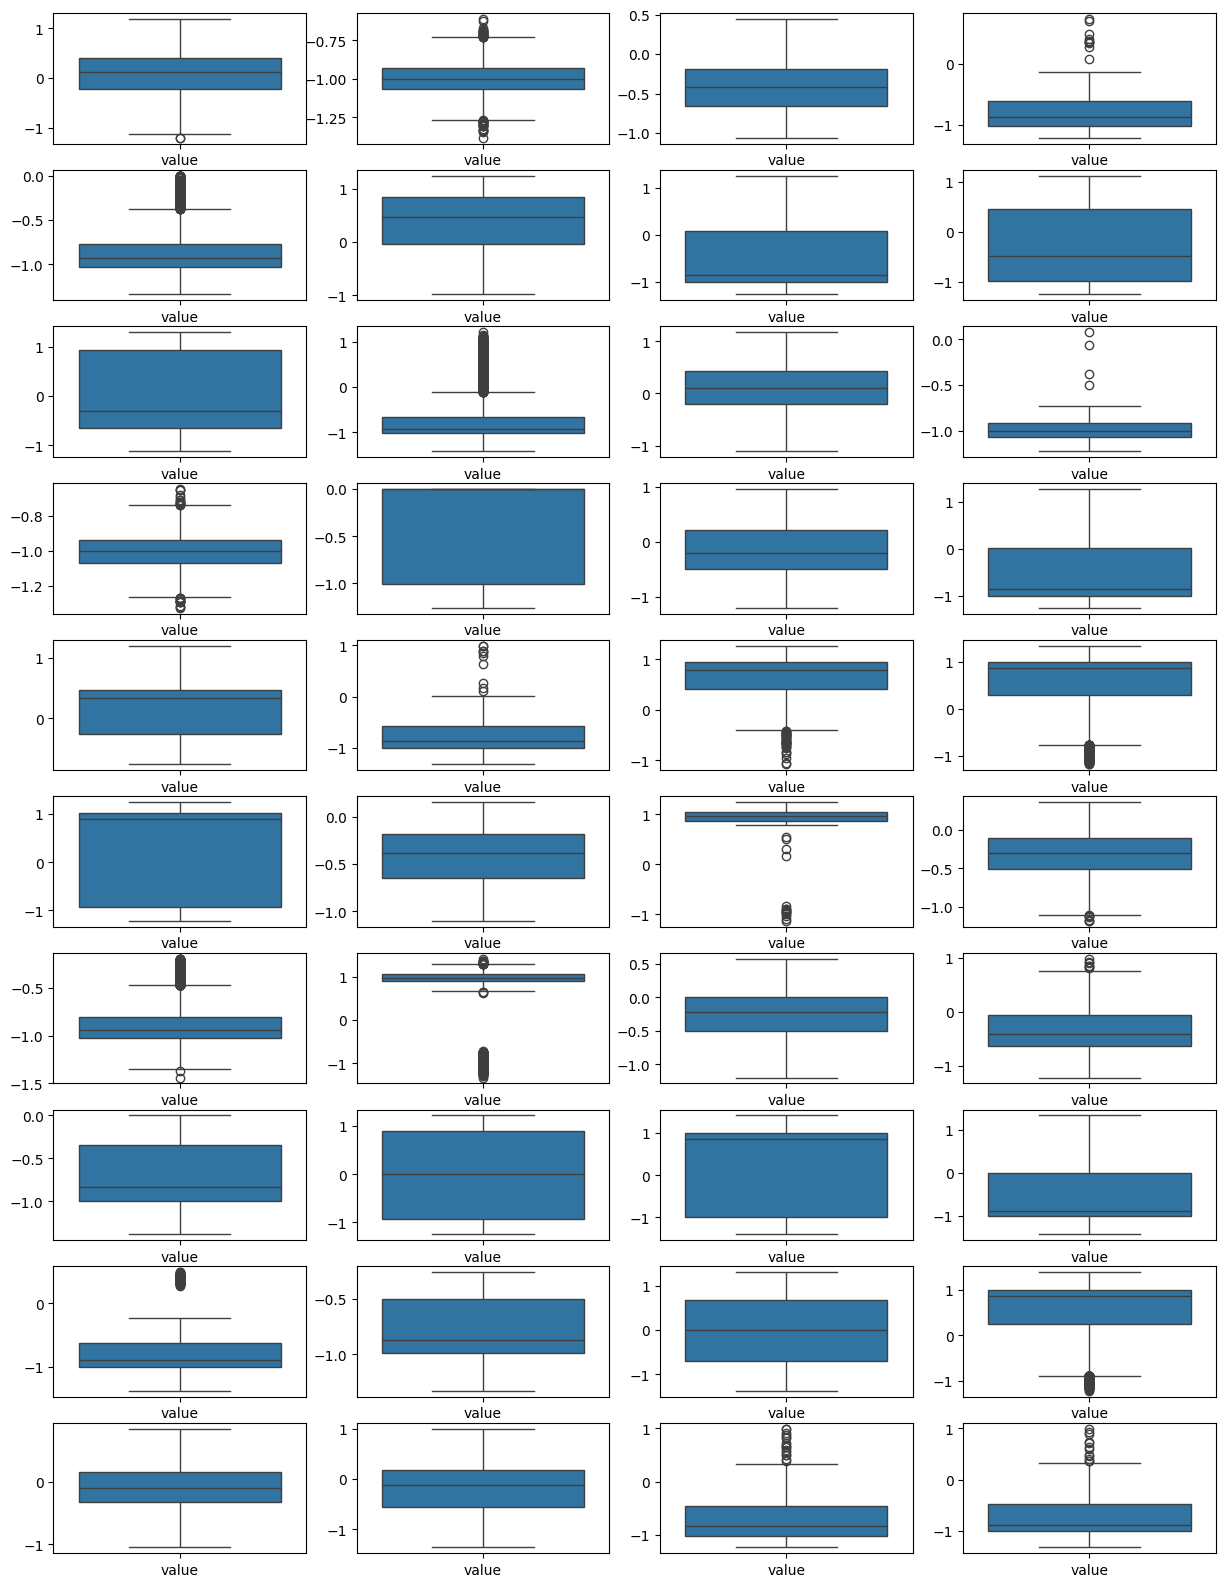

In [10]:
fig, axes = plt.subplots(10, 4, figsize=(15, 20))
for ax, dataset in zip(axes.ravel(), datasets):
    sns.boxplot(dataset, ax=ax)

plt.show()

# Data Preprocessing Pipeline

## Data Cleaning

- Impute missing values using `Interpolation`

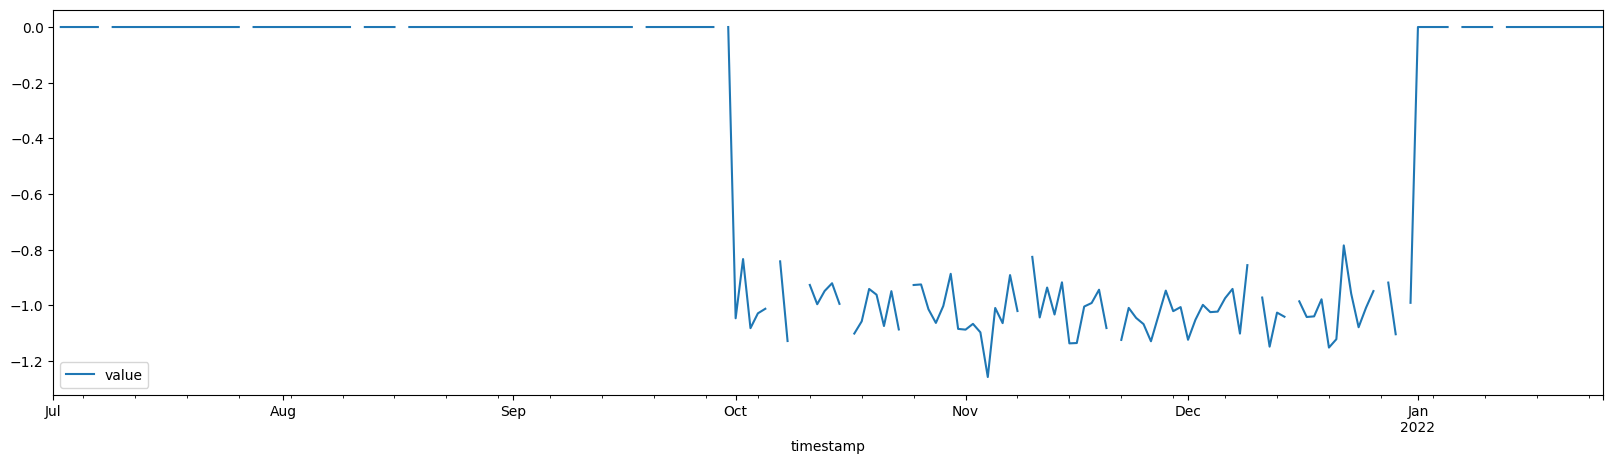

In [11]:
sample_dataset = no_missing_datasets[13].copy()

sample_dataset.plot(figsize=(20, 5))
plt.show()

In [12]:
class InterpolationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, method="linear", order=None):
        self.method = method
        self.order = order

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        X_copy = X.copy()
        X_copy.interpolate(method=self.method, order=self.order, inplace=True)

        # If the first value is NaN, replace it with the first valid value
        X_copy.bfill(inplace=True)

        return X_copy

In [13]:
interpolation_transformer = InterpolationTransformer(method="quadratic")
sample_dataset_inter = interpolation_transformer.fit_transform(sample_dataset)

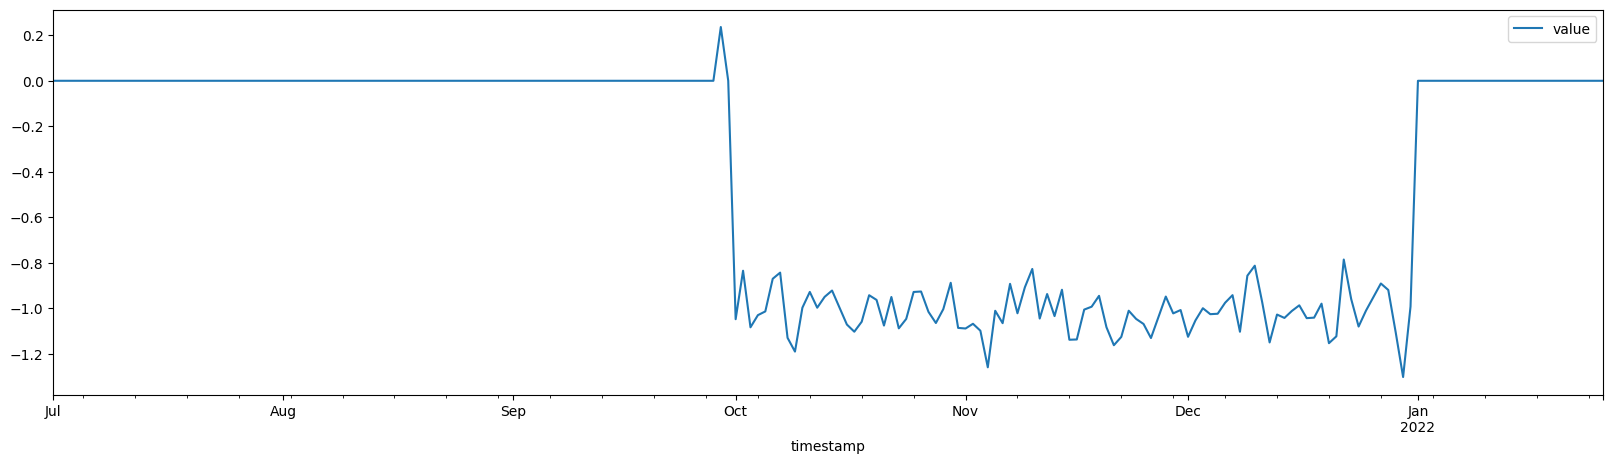

In [14]:
sample_dataset_inter.plot(figsize=(20, 5))
plt.show()

## Feature Engineering

### Seasonality

Adding Seasonality features to the dataset based on its frequencies.

In [15]:
class SeasonalityFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, top=5):
        self.top = top
        self.top_freq: None

    def fit(self, X: pd.DataFrame, y=None):
        if X.isna().sum().value > 0:
            raise ValueError("The dataset contains NaN values")

        if X.shape[1] != 1:
            raise ValueError("The dataset should contain only one column")

        # Copy the value column from the dataset
        X_copy = X.copy().value

        fft_result = np.fft.fft(X_copy)
        # Calculate only positive power spectral density and frequencies
        # Exclude the first value (0 Hz)
        psd = (np.abs(fft_result) ** 2)[: len(X_copy) // 2][1:]
        freq = np.fft.fftfreq(len(X_copy), 1)[: len(X_copy) // 2][1:]

        # Pick the top frequencies
        top_freq_indices = np.argsort(psd, axis=0)[::-1][: self.top]
        self.top_freq = freq[top_freq_indices]

        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        if X.isna().sum().value > 0:
            raise ValueError("The dataset contains NaN values")

        if X.shape[1] != 1:
            raise ValueError("The dataset should contain only one column")

        X_copy = X.copy().index.values.astype(float)

        # Calculate the seasonality features
        seasonality_features = pd.DataFrame(
            index=X.index,
            columns=[f"seasonality_sin_{i}" for i in range(self.top)]
            + [f"seasonality_cos_{i}" for i in range(self.top)],
            dtype=float,
        )
        for i, freq in enumerate(self.top_freq):
            seasonality_features.loc[:, f"seasonality_sin_{i}"] = np.sin(
                2 * np.pi * freq * X_copy
            )
            seasonality_features.loc[:, f"seasonality_cos_{i}"] = np.cos(
                2 * np.pi * freq * X_copy
            )

        # Add the seasonality features to the dataset
        return pd.concat([X, seasonality_features], axis=1)

In [16]:
sample_dataset = datasets[13].copy()

In [17]:
# Impute the NaN values from the dataset (interpolation) before Seasonality Features
interpolation_transformer = InterpolationTransformer(method="quadratic")
sample_dataset_inter = interpolation_transformer.fit_transform(sample_dataset)

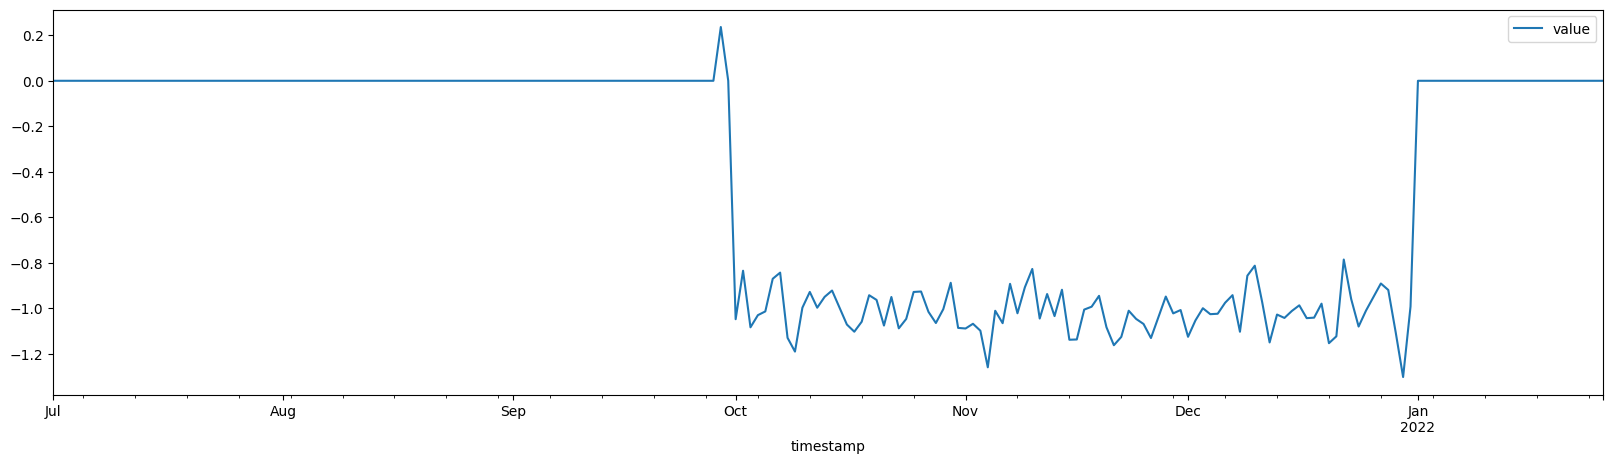

In [18]:
sample_dataset_inter.plot(figsize=(20, 5))
plt.show()

In [19]:
seasonality_transformer = SeasonalityFeaturesTransformer(top=1)
seasonality_transformer.fit(sample_dataset_inter)

SeasonalityFeaturesTransformer(top=1)

In [20]:
seasonality_transformer.top_freq

array([0.0047619])

In [21]:
sample_dataset_seasonality = seasonality_transformer.transform(sample_dataset_inter)

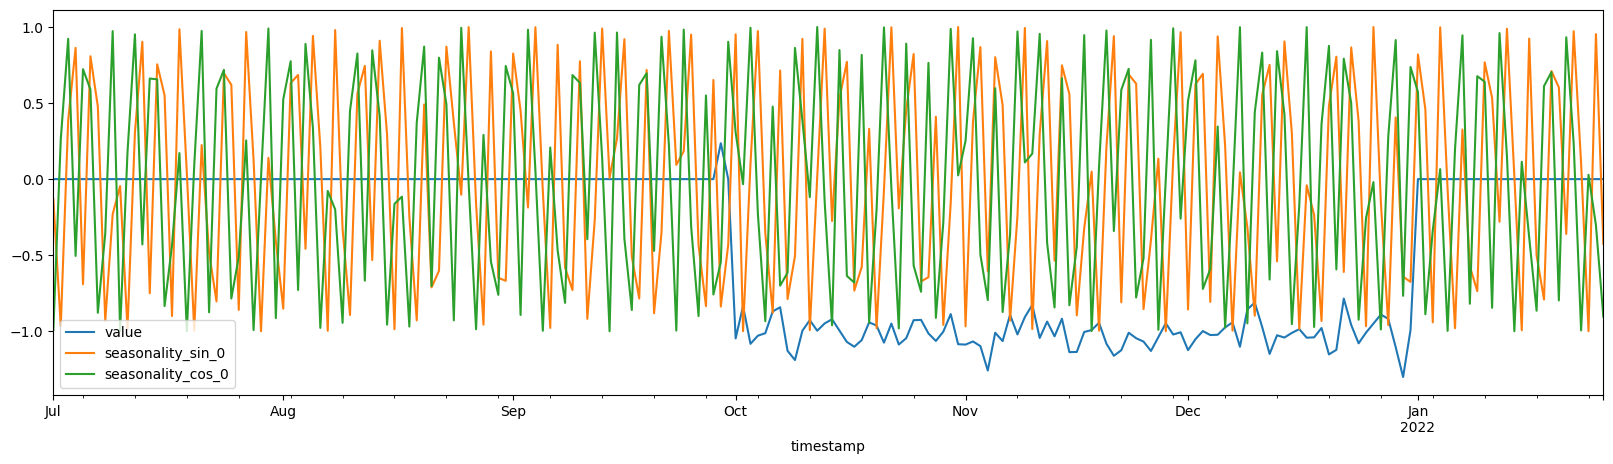

In [22]:
sample_dataset_seasonality.plot(figsize=(20, 5))
plt.show()

### Trend

In [23]:
class TrendTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=5):
        self.window_size = window_size

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        X_copy = X.copy()
        values = X_copy["value"]

        # Calculate the trend using the window average
        expanding_mean = values.expanding(self.window_size).mean().bfill().to_numpy()

        return pd.concat(
            [
                X,
                pd.DataFrame(
                    data=expanding_mean, index=X_copy.index, columns=["trend"]
                ),
            ],
            axis=1,
        )

In [24]:
trend_transformer = TrendTransformer(window_size=1)

trend_transformer.fit(sample_dataset_seasonality)

TrendTransformer(window_size=1)

In [25]:
sample_dataset_trend = trend_transformer.transform(sample_dataset_seasonality)

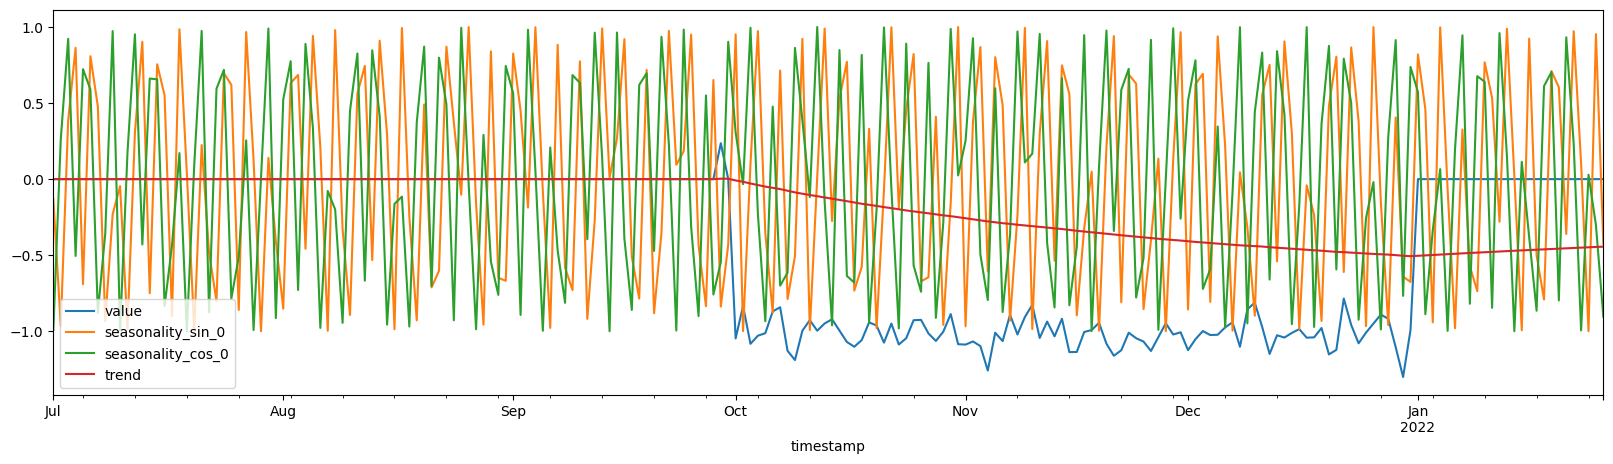

In [26]:
sample_dataset_trend.plot(figsize=(20, 5))
plt.show()

### Lagged Features

Choosing the lagged features that are highly correlated with the target variable. 

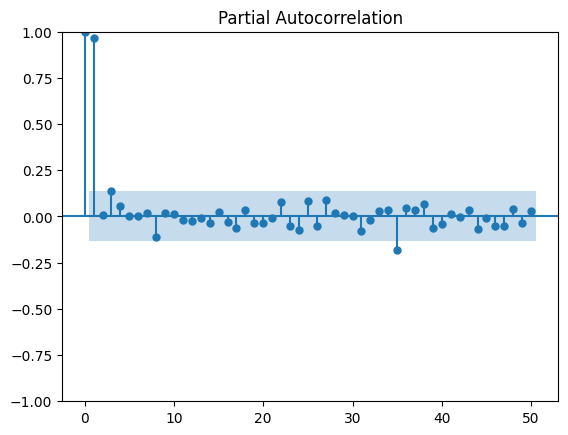

In [27]:
plot_pacf(sample_dataset_trend["value"], lags=50)
plt.show()

In [28]:
class AutocorrelationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_n_lags=5, max_lag=10):
        if 10 < max_n_lags < 1:
            raise ValueError("max_lags should be between 1 and 10")

        self.significant_lags = None
        self.max_n_lags = max_n_lags
        self.max_lag = max_lag

    def fit(self, X: pd.DataFrame, y=None):
        X_copy = X.copy()
        value = X_copy["value"]

        # Calculate the PACF values
        pacf_values = pacf(
            value,
            nlags=self.max_lag,
        )

        # Pick the top lags
        significant_lags = np.argsort(abs(np.array(pacf_values)))[::-1]
        self.significant_lags = significant_lags[1 : self.max_n_lags + 1]

        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        X_copy = X.copy()
        value = X_copy["value"]

        # Excluding the first lag (autocorrelation = 1) and Lag 0 (constant)
        correlation_features = pd.DataFrame(
            index=X_copy.index,
            columns=[f"lag_{lag}" for lag in self.significant_lags],
        )

        for lag in self.significant_lags:
            correlation_features.loc[:, f"lag_{lag}"] = value.shift(lag)

        # Backfill the NaN values
        correlation_features = correlation_features.bfill()

        return pd.concat([X, correlation_features], axis=1)

In [29]:
autocorrelation_transformer = AutocorrelationTransformer(max_n_lags=2)
autocorrelation_transformer.fit(sample_dataset_trend)

AutocorrelationTransformer(max_n_lags=2)

In [30]:
sample_dataset_lagged = autocorrelation_transformer.transform(sample_dataset_trend)

<Axes: xlabel='timestamp'>

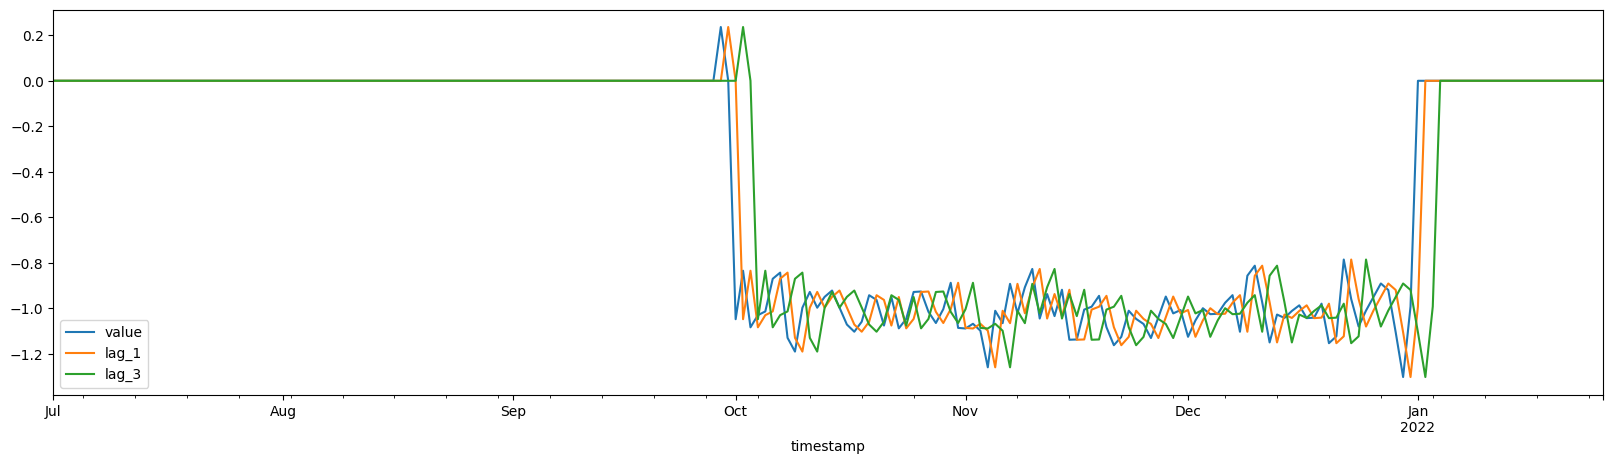

In [31]:
sample_dataset_lagged[
    ["value"] + [f"lag_{i}" for i in autocorrelation_transformer.significant_lags]
].plot(figsize=(20, 5))

## Create pipeline

In [32]:
preprocessing_pipeline = Pipeline(
    [
        ("outlier", OutlierTransformer()),
        ("interpolation", InterpolationTransformer()),
        ("seasonality", SeasonalityFeaturesTransformer()),
        ("trend", TrendTransformer()),
        ("autocorrelation", AutocorrelationTransformer()),
    ]
)

In [33]:
test_dataset = datasets[15].copy()

In [34]:
preprocessing_pipeline.fit(test_dataset)

Pipeline(steps=[('outlier', OutlierTransformer()),
                ('interpolation', InterpolationTransformer()),
                ('seasonality', SeasonalityFeaturesTransformer()),
                ('trend', TrendTransformer()),
                ('autocorrelation', AutocorrelationTransformer())])

In [35]:
test_dataset_pre = preprocessing_pipeline.transform(test_dataset)

In [36]:
test_dataset_pre.head(20)

,value,seasonality_sin_0,seasonality_sin_1,seasonality_sin_2,seasonality_sin_3,seasonality_sin_4,seasonality_cos_0,seasonality_cos_1,seasonality_cos_2,seasonality_cos_3,seasonality_cos_4,trend,lag_1,lag_5,lag_9,lag_6,lag_10
timestamp,,,,,,,,,,,,,,,,,
2021-07-01 00:00:00,0.459726,-0.918569,-0.744960,0.284135,0.222812,0.878655,-0.395261,-0.667109,0.958784,0.974861,-0.477457,0.298924,0.459726,0.459726,0.459726,0.459726,0.459726
2021-07-01 06:00:00,0.495199,0.484312,-0.948626,0.892999,0.998350,-0.808446,-0.874896,0.316399,0.450059,0.057423,0.588571,0.298924,0.459726,0.459726,0.459726,0.459726,0.459726
2021-07-01 12:00:00,0.530672,0.174696,-0.195349,0.939705,-0.736945,0.724270,-0.984623,0.980734,-0.341987,-0.675953,-0.689517,0.298924,0.495199,0.459726,0.459726,0.459726,0.459726
2021-07-01 18:00:00,0.448953,0.962474,0.754990,0.999995,-0.854408,-0.627582,0.271374,0.655736,0.003255,0.519603,0.778551,0.298924,0.530672,0.459726,0.459726,0.459726,0.459726
2021-07-02 00:00:00,-0.439928,-0.365383,0.943720,0.687609,0.261169,0.520052,0.930857,-0.330747,-0.726082,0.965293,-0.854135,0.298924,0.448953,0.459726,0.459726,0.459726,0.459726
2021-07-02 06:00:00,-0.472273,-0.044051,0.180455,-0.057639,0.999839,-0.403538,0.999029,-0.983583,-0.998337,0.017919,0.914963,0.170391,-0.439928,0.459726,0.459726,0.459726,0.459726
2021-07-02 12:00:00,-0.483305,-0.989752,-0.764846,-0.766602,-0.763085,0.280052,-0.142799,-0.644213,-0.642123,-0.646298,-0.959985,0.077006,-0.472273,0.495199,0.459726,0.459726,0.459726
2021-07-02 18:00:00,-0.445376,0.240143,-0.938596,-0.992976,-0.833203,-0.151729,-0.970738,0.345019,0.118319,0.552967,0.988422,0.011709,-0.483305,0.530672,0.459726,0.495199,0.459726
2021-07-03 00:00:00,-0.985939,-0.087355,-0.165520,-0.594254,0.299117,0.020784,-0.996177,0.986206,0.804277,0.954216,-0.999784,-0.099141,-0.445376,0.448953,0.459726,0.530672,0.459726


# Save the pipelines

In [37]:
for dataset, dataset_name in zip(datasets, datasets_names):
    with open(f"./pipelines/preprocessing/{dataset_name}.pkl", "wb") as f:
        pickle.dump(preprocessing_pipeline.fit(dataset), f)